In [1]:
import json

with open("logs.json", "r", encoding="utf-8") as f:
    data = json.load(f)


In [6]:
for log_entry in data:
  for item in log_entry['items']:
    print(item["input"])

[{'role': 'system', 'context': '\n<objective>\nYou are Cypher Query BotAI for transforming structured car-related questions into two distinct Cypher queries.\nGenerate queries using Knowledge Graph Schema and Validation Entities for name canonicalization, primarily leveraging the user input.\n</objective>\n\n<core_mandates>\n1.  Schema Use: Strictly use Knowledge Graph Schema elements (labels, relationships, properties). Crucially, never invent or assume relationships or node paths not explicitly defined in the knowledge_graph_schema.\n2.  Canonical Names & Entity Extraction:\n       Primary Entities (Brand, Model, Variant): Extract canonical brand, model, and variant names from the User Input. Always use fuzzy matching (=~) in Cypher. Never use exact matching (=), even for canonical names.\n       Specification Types (specification.spec_type): Use Validation Entities (base_kb) to identify and map user-described spec types to canonical terms. Apply fuzzy matching (=~) to those canonica

In [7]:
print(len(data))

10


In [10]:
import json
import pandas as pd
from IPython.display import display

# Load the JSON log file
with open("logs.json", "r", encoding="utf-8") as f:
    batches = json.load(f)

# Extract id, system prompt (context), and user prompt (query)
rows = []
for batch in batches:
    for item in batch["items"]:
        item_id = item["id"]
        system_ctx = item["input"][0]["context"]
        user_ctx = item["input"][1]["context"]
        rows.append({
            "id": item_id,
            "system_prompt": system_ctx,
            "user_prompt": user_ctx
        })

# Create and display a DataFrame
df = pd.DataFrame(rows)
display(df)


,id,system_prompt,user_prompt
0,41ae71ea-59db-46b7-af56-d8f5026ead56,\n<objective>\nYou are Cypher Query BotAI for ...,1. Customer's Specific Inquiry: The user is as...
1,f2530571-175f-479e-a21b-2e096d186cd8,\n<objective>\nYou are Cypher Query BotAI for ...,1. Customer's Specific Inquiry: The user is ex...
2,77e16750-3981-4751-a862-ea21bbbd2a1d,\n # CONTEXT: LANGUAGE\n - Curre...,are speakers good as i need to consider while ...
3,80e8a1e6-6ba2-4b38-9397-56b89564ca00,\n<objective>\nYou are Cypher Query BotAI for ...,1. Customer's Specific Inquiry: How the Traffi...
4,3a1d050a-502c-4af7-8ed3-9dd55f13b06a,\n<objective>\nYou are Cypher Query BotAI for ...,1. Customer's Specific Inquiry: The user is as...
5,da3e35f3-da5f-4453-9d68-5c2f951b2d85,\n<objective>\nYou are Cypher Query BotAI for ...,1. Customer's Specific Inquiry: The user does ...
6,ba7cb5ba-b87a-491f-a4a7-6ce72b26afd2,\n<objective>\nYou are Cypher Query BotAI for ...,1. Customer's Specific Inquiry: Inquiry about ...
7,710acf9d-867a-43f4-9873-70ca08989d79,\n<objective>\nYou are Cypher Query BotAI for ...,1. Customer's Specific Inquiry: Inquiry about ...
8,f7097108-3b58-415b-b3ce-31db680e1701,\n<objective>\nYou are Cypher Query BotAI for ...,1. Customer's Specific Inquiry: What is the ma...
9,9bd1b731-bd4d-4da0-85b5-33266fbc5245,\n<objective>\nYou are Cypher Query BotAI for ...,1. Customer's Specific Inquiry: Inquiry about ...


In [11]:
import json
from pathlib import Path
from sentence_transformers import SentenceTransformer, util

# 1. Configuration
INPUT_JSON = Path('logs.json')
OUTPUT_JSON = Path('ragas_scores.json')
EMBED_MODEL = SentenceTransformer('all-mpnet-base-v2')

def load_logs():
    data = json.loads(INPUT_JSON.read_text())
    # flatten items across datasets
    items = []
    for ds in data:
        items.extend(ds['items'])
    return items

def compute_embeddings(texts):
    return EMBED_MODEL.encode(texts, convert_to_tensor=True)

def faithfulness(context, response):
    # simple heuristic: entity overlap ratio
    ctx_tokens = set(context.lower().split())
    resp_tokens = response.lower().split()
    overlap = sum(1 for t in resp_tokens if t in ctx_tokens)
    return overlap / max(len(resp_tokens), 1)

def relevancy(query, response, q_emb, r_emb):
    # cosine similarity
    return float(util.cos_sim(q_emb, r_emb).item())

def context_precision(context, response):
    # sentence‑level overlap
    ctx_sents = set(context.split('.'))
    resp_sents = [s.strip() for s in response.split('.') if s.strip()]
    matched = sum(1 for s in resp_sents if any(s in c for c in ctx_sents))
    return matched / max(len(resp_sents), 1)

def main():
    items = load_logs()
    results = []
    # precompute embeddings in batch
    queries = [itm['input'][1]['context'] for itm in items]
    responses = [' '.join([out['content'] for out in itm['expectedOutput']]) for itm in items]
    q_embs = compute_embeddings(queries)
    r_embs = compute_embeddings(responses)

    for idx, itm in enumerate(items):
        ctx = itm['input'][0]['context']
        qry = queries[idx]
        resp = responses[idx]

        f = faithfulness(ctx, resp)
        r = relevancy(qry, resp, q_embs[idx], r_embs[idx])
        p = context_precision(ctx, resp)

        results.append({
            "id": itm['id'],
            "faithfulness": round(f, 3),
            "answer_relevancy": round(r, 3),
            "context_precision": round(p, 3),
        })

    OUTPUT_JSON.write_text(json.dumps(results, indent=2))
    print(f"Wrote {len(results)} RAGAs scores to {OUTPUT_JSON}")

if __name__ == "__main__":
    main()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Wrote 10 RAGAs scores to ragas_scores.json


In [35]:
import json
from pathlib import Path
from typing import List, Tuple

# Optional advanced imports
try:
    from transformers import pipeline
    from sentence_transformers import SentenceTransformer, util, CrossEncoder
    ADVANCED_AVAILABLE = True
except ImportError:
    ADVANCED_AVAILABLE = False


def load_logs(input_path: Path) -> List[dict]:
    data = json.loads(input_path.read_text())
    items = []
    for ds in data:
        items.extend(ds.get('items', []))
    return items


def compute_embeddings(model: SentenceTransformer, texts: List[str]) -> 'torch.Tensor':
    return model.encode(texts, convert_to_tensor=True)


def faithfulness_overlap(context: str, response: str) -> float:
    ctx_tokens = set(context.lower().split())
    resp_tokens = response.lower().split()
    if not resp_tokens:
        return 0.0
    overlap = sum(1 for t in resp_tokens if t in ctx_tokens)
    return overlap / len(resp_tokens)


def relevancy_cosine(q_emb, r_emb) -> float:
    return float(util.cos_sim(q_emb, r_emb).item())


def context_precision_overlap(context: str, response: str) -> float:
    ctx_sents = [s.strip() for s in context.split('.') if s.strip()]
    resp_sents = [s.strip() for s in response.split('.') if s.strip()]
    if not resp_sents:
        return 0.0
    matched = sum(1 for rs in resp_sents if any(rs in cs for cs in ctx_sents))
    return matched / len(resp_sents)

#--- Advanced metrics ---#

def init_advanced_models(device: str = 'cpu') -> Tuple[pipeline, CrossEncoder, SentenceTransformer]:
    nli = pipeline("text-classification", model="roberta-large-mnli", device=device)
    cross_encoder = CrossEncoder("cross-encoder/stsb-roberta-large", device=device)
    sem_model = SentenceTransformer('all-mpnet-base-v2', device=device)
    return nli, cross_encoder, sem_model


def faithfulness_nli(nli, context: str, response: str) -> float:
    clauses = [cl.strip() for cl in response.split('\n') if cl.strip()]
    if not clauses:
        return 0.0
    entail = 0
    for clause in clauses:
        result = nli(context, clause, truncation=True)
        top = max(result, key=lambda x: x['score'])
        if top['label'] == 'ENTAILMENT':
            entail += 1
    return entail / len(clauses)


def relevancy_cross(cross_encoder, query: str, response: str) -> float:
    score = cross_encoder.predict([(query, response)])[0]
    # scale [-5,5] -> [0,1]
    return (score + 5) / 10


def context_precision_semantic(sem_model, context: str, response: str, thresh: float = 0.7) -> float:
    ctx_sents = [s.strip() for s in context.split('.') if s.strip()]
    clauses = [cl.strip() for cl in response.split('\n') if cl.strip()]
    if not clauses:
        return 0.0
    ctx_e = sem_model.encode(ctx_sents, convert_to_tensor=True)
    rsp_e = sem_model.encode(clauses, convert_to_tensor=True)
    sim = util.cos_sim(rsp_e, ctx_e)
    covered = (sim >= thresh).any(dim=1).sum().item()
    return covered / len(clauses)


class Args:
    input = Path('logs.json')
    output = Path('ragas_scores.json')
    advanced = False
    device = 'cpu'

args = Args()

items = load_logs(args.input)
results = []

# Initialize basic embedder
embedder = SentenceTransformer('all-mpnet-base-v2', device=args.device)

if args.advanced:
    if not ADVANCED_AVAILABLE:
        raise ImportError("Advanced metrics require transformers and CrossEncoder installed.")
    nli, cross_enc, sem_mod = init_advanced_models(device=args.device)

# Precompute embeddings for relevancy
queries = [itm['input'][1]['context'] for itm in items]
responses = [' '.join(o['content'] for o in itm['expectedOutput']) for itm in items]
q_embs = compute_embeddings(embedder, queries)
r_embs = compute_embeddings(embedder, responses)

for idx, itm in enumerate(items):
    ctx = itm['input'][0]['context']
    qry = queries[idx]
    rsp = responses[idx]

    if args.advanced:
        f = faithfulness_nli(nli, ctx, rsp)
        r = relevancy_cross(cross_enc, qry, rsp)
        p = context_precision_semantic(sem_mod, ctx, rsp)
    else:
        f = faithfulness_overlap(ctx, rsp)
        r = relevancy_cosine(q_embs[idx], r_embs[idx])
        p = context_precision_overlap(ctx, rsp)

    results.append({
        'id': itm['id'],
        'faithfulness': round(f, 3),
        'answer_relevancy': round(r, 3),
        'context_precision': round(p, 3),
    })

args.output.write_text(json.dumps(results, indent=2))
print(f"Computed {len(results)} items; saved to {args.output}")

Computed 10 items; saved to ragas_scores.json


,id,faithfulness,answer_relevancy,context_precision
0,41ae71ea-59db-46b7-af56-d8f5026ead56,0.596,0.295,0.357
1,f2530571-175f-479e-a21b-2e096d186cd8,0.635,0.346,0.190
2,77e16750-3981-4751-a862-ea21bbbd2a1d,0.733,0.503,0.000
3,80e8a1e6-6ba2-4b38-9397-56b89564ca00,0.535,0.221,0.357
4,3a1d050a-502c-4af7-8ed3-9dd55f13b06a,0.565,0.199,0.406


,faithfulness,answer_relevancy,context_precision
count,10.000000,10.000000,10.000000
mean,0.624300,0.261700,0.357200
std,0.105754,0.110215,0.159627
min,0.466000,0.143000,0.000000
25%,0.542500,0.196000,0.350250
50%,0.615500,0.224000,0.381500
75%,0.727000,0.325750,0.432250
max,0.754000,0.503000,0.545000


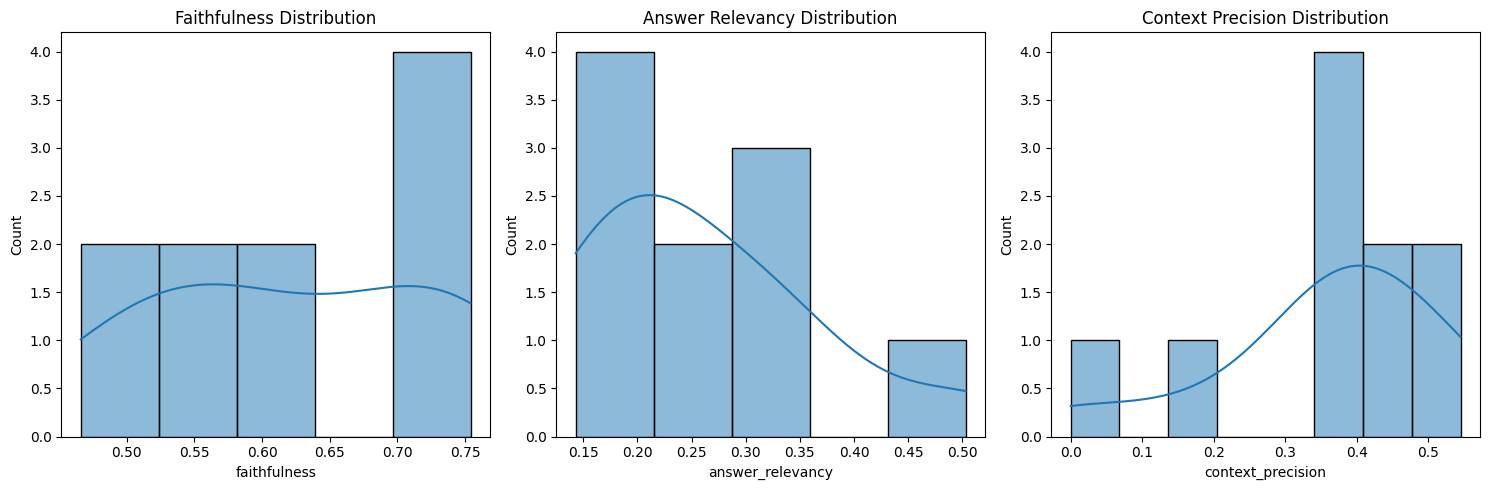

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the results into a pandas DataFrame
ragas_df = pd.read_json('ragas_scores.json')

# Display the first few rows of the DataFrame
display(ragas_df.head())

# Get some basic statistics for the scores
display(ragas_df.describe())

# Visualize the distribution of the scores
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(ragas_df['faithfulness'], kde=True)
plt.title('Faithfulness Distribution')

plt.subplot(1, 3, 2)
sns.histplot(ragas_df['answer_relevancy'], kde=True)
plt.title('Answer Relevancy Distribution')

plt.subplot(1, 3, 3)
sns.histplot(ragas_df['context_precision'], kde=True)
plt.title('Context Precision Distribution')

plt.tight_layout()
plt.show()